# Gas consumption Analysis

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd

# Status overview & Dataframe Preparation

In [7]:
gc01 = pd.read_csv("/Users/xinyuyangren/Documents/TU:e_Year2/Thesis/Aramis_Data_Warehouse/Consumption_Study/0300_gc.csv")

In [8]:
gc01 = gc01.dropna()

In [9]:
gc01.describe()

,avg_windspeed,avg_irradiation,avg_rh,avg_t,avg_wc_lr,avg_wc_br2,avg_wc_br1_br3,set_point_ventilation_unit,avg_t_lr,avg_t_br2,avg_t_br1_br3,avg_co2_lr,avg_co2_br2,avg_co2_br1_br3,gc
count,15994.000000,15994.000000,15994.000000,15994.000000,15994.000000,15994.000000,15994.000000,15994.000000,15994.000000,15994.000000,15994.000000,15994.000000,15994.000000,15994.000000,15994.000000
mean,1.919657,121.031824,78.569964,11.779555,0.999318,0.432415,0.331504,1.127298,22.704808,22.540290,21.771070,851.416450,758.468513,720.749406,0.057432
std,1.687856,200.287064,15.736454,6.693290,0.023112,0.486629,0.464399,0.404039,1.769490,1.993261,2.367904,230.255692,102.720935,141.611734,0.093954
min,0.000000,-576.000000,0.000000,-90.000000,0.000000,0.000000,0.000000,1.000000,15.400000,17.000000,14.700000,486.300000,529.400000,470.700000,0.000000
25%,1.000000,-4.000000,69.000000,7.000000,1.000000,0.000000,0.000000,1.000000,21.800000,21.400000,20.100000,675.925000,695.800000,611.625000,0.000000
50%,2.000000,3.000000,82.000000,11.800000,1.000000,0.000000,0.000000,1.000000,22.400000,21.800000,21.100000,794.600000,748.600000,693.300000,0.000000
75%,3.000000,175.000000,91.000000,16.500000,1.000000,1.000000,1.000000,1.000000,23.700000,23.800000,23.400000,968.475000,811.500000,816.500000,0.087000
max,13.000000,957.000000,100.000000,34.300000,1.000000,1.000000,1.000000,3.000000,28.000000,29.300000,29.800000,3322.900000,1924.900000,1938.900000,1.066000


In [10]:
# Deal with the datetime attributes

gc01.timestamp = pd.to_datetime(gc01.timestamp)
t = pd.DatetimeIndex(gc01.timestamp)
hr = t.hour
gc01['HourOfDay'] = hr
month = t.month
gc01['Month'] = month

In [11]:
for column in gc01.columns:
    print column

timestamp
avg_windspeed
avg_irradiation
avg_rh
avg_t
avg_wc_lr
avg_wc_br2
avg_wc_br1_br3
set_point_ventilation_unit
avg_t_lr
avg_t_br2
avg_t_br1_br3
avg_co2_lr
avg_co2_br2
avg_co2_br1_br3
gc
HourOfDay
Month


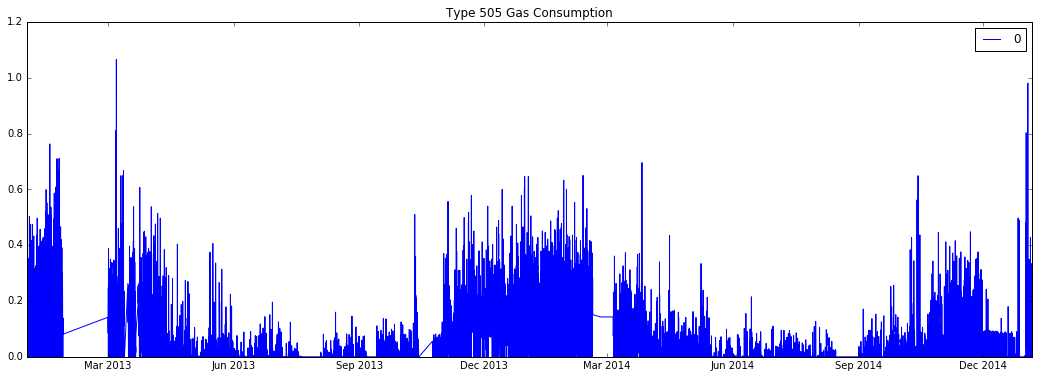

In [12]:
fig = plt.figure(figsize=(18,6), dpi=1600) 
plt.plot(gc01.timestamp,gc01.gc) 
plt.ylim(0,1.2)
plt.legend(('0300'),loc='best') 
plt.title('Type 505 Gas Consumption')

Run Above here to pre-process the dataset

# Gas consumption: Impact factor Study

In [13]:
gc = gc01.pop('gc')
timestamp = gc01.pop('timestamp')

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score

In [15]:
rf = RandomForestRegressor(n_estimators=1000,n_jobs=-1,oob_score=True)

In [16]:
rf.fit(gc01,gc)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=-1, oob_score=True, random_state=None,
           verbose=0, warm_start=False)

/Users/xinyuyangren/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: sort is deprecated, use sort_values(inplace=True) for for INPLACE sorting
  from ipykernel import kernelapp as app


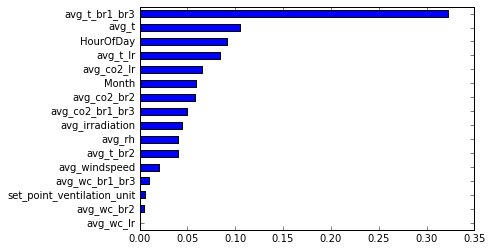

In [17]:
feature_importances = pd.Series(rf.feature_importances_,index = gc01.columns)
feature_importances.sort(inplace = True)
feature_importances.plot(kind = 'barh')

In [18]:
pred = rf.predict(gc01)

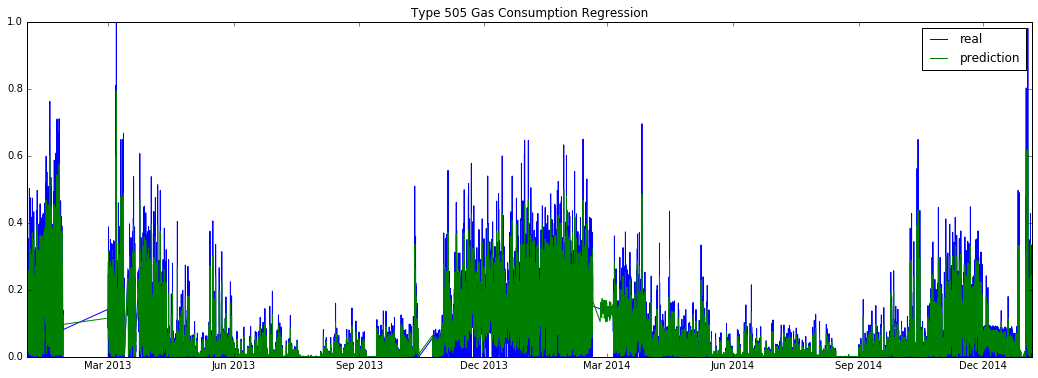

In [19]:
fig = plt.figure(figsize=(18,6), dpi=1600) 
plt.plot(timestamp,gc) 
plt.plot(timestamp,pred) 
plt.ylim(0,1.0)
plt.legend(('real','prediction'),loc='best') 
plt.title('Type 505 Gas Consumption Regression')

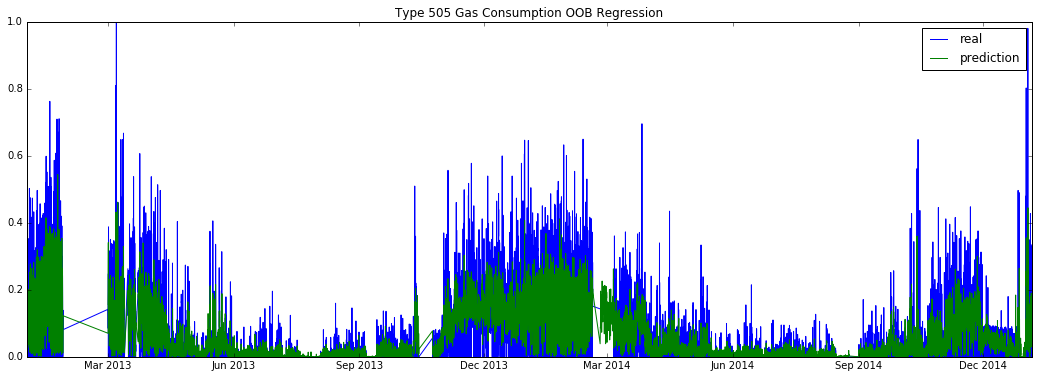

In [20]:
predoob = rf.oob_prediction_
fig = plt.figure(figsize=(18,6), dpi=1600) 
plt.plot(timestamp,gc) 
plt.plot(timestamp,predoob) 
plt.ylim(0,1.0)
plt.legend(('real','prediction'),loc='best') 
plt.title('Type 505 Gas Consumption OOB Regression')

In [21]:
print rf.score(gc01,gc)

0.937604432165


In [22]:
print rf.oob_score_

0.541850296307


0.639664423775 0.15022787441 0.210107701815


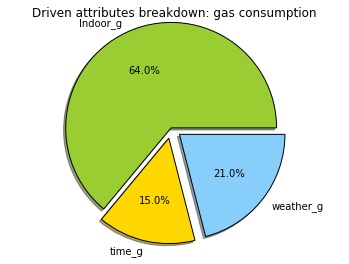

In [25]:
# Motivation breakdown

weather_g = feature_importances.avg_t + feature_importances.avg_rh\
+ feature_importances.avg_windspeed + feature_importances.avg_irradiation

time_g = feature_importances.Month + feature_importances.HourOfDay

behavior_g = feature_importances.avg_t_br1_br3 + feature_importances.avg_t_lr + feature_importances.avg_co2_lr\
+ feature_importances.avg_co2_lr

Indoor_g = 1 - time_g - weather_g

print Indoor_g, time_g, weather_g

# The slices will be ordered and plotted counter-clockwise.
labels = 'Indoor_g', 'time_g', 'weather_g'
sizes = [Indoor_g, time_g, weather_g]
colors = ['yellowgreen', 'gold', 'lightskyblue']
explode = (0, 0.1, 0.1) # only "explode" the 2nd slice (i.e. 'Hogs')

plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=0)
# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')

plt.title('Driven attributes breakdown: gas consumption')
plt.show()

# Try without behavior attributes (IAT, Window and SPV)

--PREPROCESS THE DATASET AGAIN--

In [116]:
gc01 = pd.read_csv("/Users/xinyuyangren/Documents/TU:e_Year2/Thesis/Aramis_Data_Warehouse/Consumption_Study/0300_gc.csv")

In [117]:
gc01 = gc01.dropna()
gc01.timestamp = pd.to_datetime(gc01.timestamp)
t = pd.DatetimeIndex(gc01.timestamp)
hr = t.hour
gc01['HourOfDay'] = hr
month = t.month
gc01['Month'] = month

In [118]:
gc = gc01.pop('gc')
timestamp = gc01.pop('timestamp')

In [119]:
gc01 = gc01.drop(['avg_wc_lr','avg_wc_br2','avg_wc_br1_br3','set_point_ventilation_unit','avg_t_lr','avg_t_br2','avg_t_br1_br3'],axis = 1)

In [120]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score

In [121]:
rf2 = RandomForestRegressor(n_estimators=1000,n_jobs=-1,oob_score=True)

In [122]:
gc01

,avg_windspeed,avg_irradiation,avg_rh,avg_t,avg_co2_lr,avg_co2_br2,avg_co2_br1_br3,HourOfDay,Month
0,4,181,72,7.7,1024.7,717.1,770.0,0,1
1,3,96,72,7.2,939.1,914.2,900.6,1,1
2,2,44,74,6.9,863.9,823.1,736.8,2,1
3,2,-1,77,6.2,765.4,624.5,592.9,3,1
4,2,-3,79,5.9,646.1,577.2,589.0,4,1
5,1,-4,84,5.5,575.5,566.9,596.6,5,1
6,1,-3,83,5.6,549.3,581.7,661.5,6,1
7,2,-3,86,5.3,566.6,634.4,672.4,7,1
8,2,-3,86,5.4,570.5,612.0,627.9,8,1
9,1,-2,84,5.7,569.9,605.4,632.0,9,1


In [123]:
rf2.fit(gc01,gc)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=-1, oob_score=True, random_state=None,
           verbose=0, warm_start=False)

In [124]:
pred2 = rf2.predict(gc01)

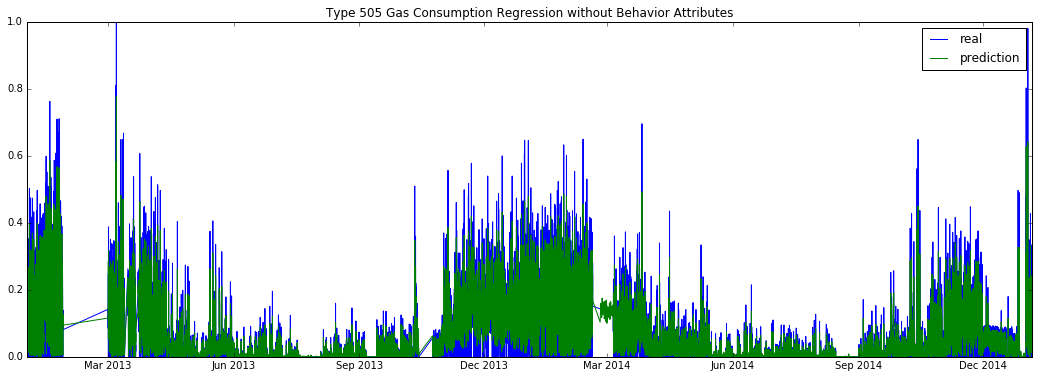

In [125]:
fig = plt.figure(figsize=(18,6), dpi=1600) 
plt.plot(timestamp,gc) 
plt.plot(timestamp,pred) 
plt.ylim(0,1.0)
plt.legend(('real','prediction'),loc='best') 
plt.title('Type 505 Gas Consumption Regression without Behavior Attributes')

In [129]:
print rf2.score(gc01,gc)

0.934029682382


In [126]:
print rf2.oob_score_

0.512505175797


/Users/xinyuyangren/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: sort is deprecated, use sort_values(inplace=True) for for INPLACE sorting
  from ipykernel import kernelapp as app


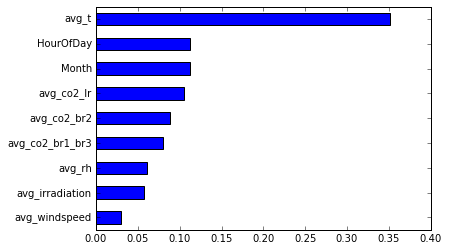

In [127]:
feature_importances = pd.Series(rf2.feature_importances_,index = gc01.columns)
feature_importances.sort(inplace = True)
feature_importances.plot(kind = 'barh')

In [130]:
pred2oob = rf2.oob_prediction_

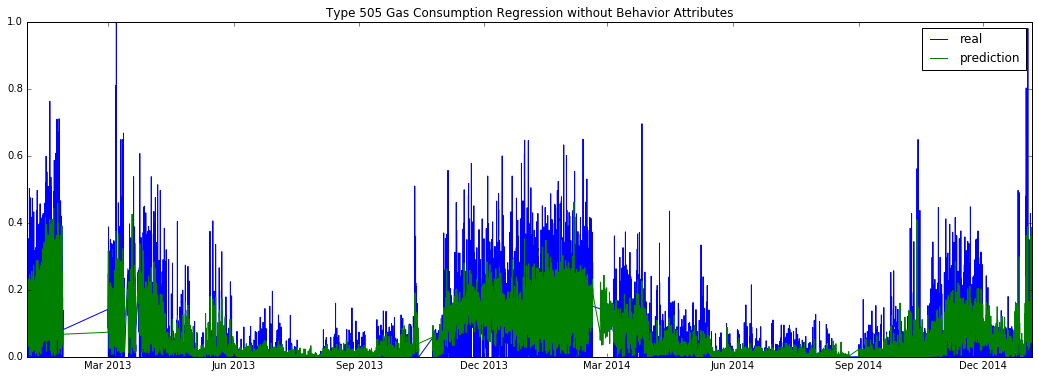

In [131]:
fig = plt.figure(figsize=(18,6), dpi=1600) 
plt.plot(timestamp,gc) 
plt.plot(timestamp,pred2oob) 
plt.ylim(0,1.0)
plt.legend(('real','prediction'),loc='best') 
plt.title('Type 505 Gas Consumption OOB Regression without Behavior Attributes')